In [209]:
# Squid CPUE Modeling: GLBM & GAM Evaluation

# --------------------------------------------------
# This notebook trains and evaluates two models:
# - GLBM (Generalized Linear Biomass Model)
# - GAM (Generalized Additive Model)
# using monthly CPUE, with full diagnostics.

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import os
from patsy import bs
import plotly.graph_objects as go
import plotly.express as px
from pygam import LinearGAM, s, f
from pygam import GammaGAM, s, f
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
import statsmodels.api as sm


In [61]:
# Load and prepare data
df = pd.read_csv("../data/Final_dataset.csv")
required_cols = ["SqCatch_Kg", "Depth", "Lat", "Lon", "WaterTemp", "Chlor_a_mg_m3", "Month", "Year", "Day", "SSH"]
df.dropna(subset=required_cols, inplace=True)

# Filter for Jan–June
df = df[df["Month"].between(1, 6)]

# Create CPUE per day
df["CPUE"] = df["SqCatch_Kg"] 
df.head()


,POINTID,CTNO,Year,Month,Day,Lon,Lat,WaterTemp,SSH,Depth,Chlor_a_mg_m3,SqCatch_Kg,CPUE
0,1,10001,2000,1,1,-60.758637,-46.297230,14.0,0.0201,80.0,0.903811,13922.858090,13922.858090
1,2,10001,2000,1,2,-60.589546,-46.319036,13.9,0.0201,85.0,0.903811,4284.774801,4284.774801
2,3,10001,2000,1,3,-60.653497,-46.096548,14.7,0.0201,85.0,0.903811,8263.649496,8263.649496
3,4,10001,2000,1,4,-60.697349,-45.962174,15.6,0.0201,85.0,0.903811,12870.823170,12870.823170
4,5,10001,2000,1,5,-60.691715,-46.148531,14.2,0.0201,90.0,0.903811,5637.852315,5637.852315


In [62]:
# Compute Monthly CPUE
monthly_cpue = (
    df.groupby(["Year", "Month"])
    .agg(
        TotalCatch=("CPUE", "sum"),
        DaysFished=("Day", "count")
    )
    .reset_index()
)
monthly_cpue["Monthly_CPUE"] = monthly_cpue["TotalCatch"] / monthly_cpue["DaysFished"]
monthly_cpue.sort_values(["Year", "Month"], inplace=True)

# Compute weighted average Latitude and Longitude per Year and Month
def weighted_mean(group, value_col, weight_col):
    return (group[value_col] * group[weight_col]).sum() / group[weight_col].sum()

weighted_coords = (
    df.groupby(["Year", "Month"])
    .apply(lambda g: pd.Series({
        "Weighted_Latitude": weighted_mean(g, "Lat", "CPUE"),
        "Weighted_Longitude": weighted_mean(g, "Lon", "CPUE")
    }))
    .reset_index()
)

# Merge back with features
ftba = ["WaterTemp", "Depth"] # "ftba" stands for features to be avergaed
aaf = ["SSH", "Chlor_a_mg_m3"] # "aaf" stands for already avergaed features

#Creating dataframes to merge after grouping them by months.
averaged_features = df.groupby(["Year", "Month"])[ftba].mean().reset_index()
already_averaged = df.groupby(["Year", "Month"])[aaf].first().reset_index()
data = monthly_cpue.merge(averaged_features, on=["Year", "Month"]).merge(weighted_coords, on=["Year", "Month"]).merge(already_averaged, on=["Year", "Month"])
data.head()


,Year,Month,TotalCatch,DaysFished,Monthly_CPUE,WaterTemp,Depth,Weighted_Latitude,Weighted_Longitude,SSH,Chlor_a_mg_m3
0,2000,1,2.588951e+07,2177,11892.288772,13.772538,76.641709,-46.533534,-60.723543,0.0201,0.903811
1,2000,2,6.305128e+07,2737,23036.638502,13.234984,78.006577,-47.162833,-61.276076,0.0178,1.546665
2,2000,3,7.175835e+07,2944,24374.440194,12.151003,84.641644,-47.567805,-60.756138,0.0150,0.690164
3,2000,4,3.532778e+07,2822,12518.701380,10.106035,96.687810,-48.823479,-61.871991,0.0097,0.591688
4,2000,5,2.437390e+07,2739,8898.831789,8.781864,107.336254,-47.660462,-61.109375,0.0109,0.442545


In [ ]:
# Log-transform CPUE for GLBM (with c = 10% of mean yearly CPUE)
yearly_mean_cpue = (
    data.groupby("Year")["Monthly_CPUE"].mean()
)
yearly_mean_cpue.name = "Yearly_Mean_CPUE"

# Merge back to full data
data_df =  data.merge(yearly_mean_cpue, on="Year")

# finding 10% of Yearly_Mean_CPUE(constant/c) in data to avoid zero when log-transforming CPUE
data_df["c"] =  0.1 * data_df["Yearly_Mean_CPUE"]

#log Transforming the monthly CPUE + c then adding it to a new column in the full df
data_df["Log_CPUE_plus_c"] = np.log(data_df["Monthly_CPUE"] + data_df["c"])


#log Transforming the monthly CPUE + 1 then adding it to a new column in the full df
data_df["Log_CPUE_plus_1"] = np.log(data_df["Monthly_CPUE"] + 1)


# Features and Target
glbm_features = ["Month", "Year", "Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Chlor_a_mg_m3", "SSH", "Depth"]

# setting the "Year" column as integer
data_df["Year"] = data_df["Year"].astype(int)


#Making a copy of the full dataset for standardization
full_df = data_df



#Double checking if there are values that are zero or below in the full dataframe to know which methid aside from linear GAM takes priority for predictions
num_values_zero_and_below = (full_df["Monthly_CPUE"] <= 0).sum()
total_values = len(full_df["Monthly_CPUE"])

if num_values_zero_and_below == 0:
    print(f"Since there are:{num_values_zero_and_below} values out of {total_values} then it would be best to proceed with GammaGam and maybe consider TweedieGAM for outliers")
else:
    print(f"Since there are:{num_values_zero_and_below} values out of {total_values} then it would be best to proceed with TweedieGam")

# Split: 2000-2014 (train), 2015-2020 (test)
train_df = full_df[full_df["Year"] < 2014].copy()
test_df = full_df[full_df["Year"] >= 2015].copy()
#y_test = test_df["Monthly_CPUE"]  # for evaluation

Since there are:0 values out of 110 then it would be best to proceed with GammaGam and maybe consider TweedieGAM for outliers


In [152]:
# Standardization Using LinearGAM (GLBM)(log(CPUE + c))
# Features and Target
features = ["Month", "Year", "Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Chlor_a_mg_m3", "SSH", "Depth"]

#Making a copy of the full dataset for standardization
full_df = data_df

#Subsetting full_df for only the features we would need to train the data
X_all = full_df[features]

# Target for LinearGAM 
y_all = full_df["Log_CPUE_plus_c"]

# Fit GLBM (GAM-like structure)
linear_gam_c_std = LinearGAM(f(0) + f(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7))

# Fit the model on full data
linear_gam_c_std.fit(X_all, y_all)

# Predict standardized log(CPUE + c) for every row
linear_gam_c_all = linear_gam_c_std.predict(X_all)

# Back-transform to standardized CPUE
standardized_log_cpueC = np.exp(linear_gam_c_all) - full_df["c"]

# Store result
full_df["Standardized_log_cpueC"] = standardized_log_cpueC


In [154]:
# Standardization Using Linear_GAM (log(CPUE + 1))
# Select features used in the model 
features = ["Year", "Month", "Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Depth"]
X_all = full_df[features]

# Target for LinearGAM 
y_all = full_df["Log_CPUE_plus_1"]

# Fit the GAM model on full data
linear_gam_1_std = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5)).fit(X_all, y_all)

# Predict on all data (standardized log(CPUE + 1))
linear_gam_1_all = linear_gam_1_std.predict(X_all)

# Back-transform to CPUE
standardized_log_cpue1 = np.exp(linear_gam_1_all) - 1

# Store result
full_df["Standardized_log_cpue1"] = standardized_log_cpue1



In [155]:
# Standardization Using GammaGAM
# Features and Target
features = ["Month", "Year", "Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Chlor_a_mg_m3", "SSH", "Depth"]


# Features
X_all = full_df[features]

# Target for GammaGAM (no log-transform needed)
y_all = full_df["Monthly_CPUE"]

# Fit GammaGAM
# Because CPUE can vary sharply between months (e.g., seasonal fishing behavior, spawning), we will use a factor for flexibility.
# Since years often follow a longer trend (e.g., stock depletion, climate change) we will use a spline to prevent overfitting the yearly spikes and ensure better generalization to other years. This was seen in the trend from the time series EDA we could have seen that the yearly spikes are real but rare .
gamma_gam_std = GammaGAM(f(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7))
gamma_gam_std.fit(X_all, y_all)

# Predict CPUE 
gamma_gam_std_all = gamma_gam_std.predict(X_all)

# Subtract the constant to get back standardized CPUE
standardized_cpue_GammaGAM = gamma_gam_std_all 

# Store result
full_df["Standardized_CPUE_GammaGAM"] = standardized_cpue_GammaGAM


In [157]:
# Standardization Using tweedieglm
# Create the formula with splines
formula = """
Monthly_CPUE ~ C(Month) + bs(Year, df=6) + bs(Weighted_Latitude, df=6) +
 bs(Weighted_Longitude, df=6) + bs(WaterTemp, df=6) + 
bs(Chlor_a_mg_m3, df=6) + bs(SSH, df=6) + bs(Depth, df=6)
"""

# Fit the model
tweedie_glm = smf.glm(formula=formula, data=full_df,
family=sm.families.Tweedie(var_power=1.5, link=sm.families.links.log())).fit()

# Predict
full_df["Standardized_CPUE_tweedieglm"] = tweedie_glm.predict(full_df)



In [158]:
# Prediction Using LinearGAM (GLBM)(log(CPUE + c))
# Features and Target
features = ["Month", "Year", "Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Chlor_a_mg_m3", "SSH", "Depth"]
X_train = train_df[features]
X_test = test_df[features]

#log transforming data for training
y_train = np.log(train_df["Monthly_CPUE"] + train_df["c"])
y_test_linear = test_df["Monthly_CPUE"]  # for evaluation

# Fit GLBM (GAM-like structure)
linear_gam_c_prd = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7))

# Train the model on part of the data
linear_gam_c_prd.fit(X_train, y_train)

# Predict log(CPUE + c) on test set
linear_gam_c_preds = linear_gam_c_prd.predict(X_test)

#Saving constant column for evaluation
lin_gam_c = test_df["c"]

# Back-transform to predicted CPUE (standardized)
linear_gam_c_preds_all = np.exp(linear_gam_c_preds) - lin_gam_c

#checking the amount of negatives values for glbm_preds
num_negatives = (linear_gam_c_preds_all < 0).sum()
total_preds = len(linear_gam_c_preds_all)
percent_negative = (num_negatives / total_preds) * 100

print(f"Negative predictions: {num_negatives} out of {total_preds} ({percent_negative:.2f}%)")

# 6 out of 29 predictions (20.69%) being negative means that about 1 in 5 predictions is unusable — which can bias results and understate CPUE trends hence why we clip to 0.
# The current LinearGAM with log-transformed CPUE (log(CPUE + c)) is not modeling the data well enough to avoid invalid predictions.

linear_gam_c_preds_all = linear_gam_c_preds_all.clip(lower=0)


Negative predictions: 10 out of 29 (34.48%)


In [159]:
# Prediction Using LinearGAM GAM (log(CPUE + 1))

# Select features used in the model
features = ["Year", "Month","Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Depth"]

X_train = train_df[features]
X_test = test_df[features]

#log transforming data for training
y_train = np.log(train_df["Monthly_CPUE"] + 1)
y_test_linear = test_df["Monthly_CPUE"]  # for evaluation

# Fit GAM
linear_gam_1_prd = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5)).fit(X_train, y_train)

# Predict on test
linear_gam_1_preds = linear_gam_1_prd.predict(X_test)
linear_gam_1_preds_all = np.exp(linear_gam_1_preds) - 1


In [160]:
# Prediction Using GammaGAM (general additive model, with spline automation defined only for positive and continuous outcomes)
# Features and Target
features = ["Month", "Year", "Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Chlor_a_mg_m3", "SSH", "Depth"]
X_train = train_df[features]
X_test = test_df[features]

# Ensuring strictly positive CPUE by adding a small constant 
y_train = train_df["Monthly_CPUE"]
y_test_gamma = test_df["Monthly_CPUE"]  # for evaluation

# Training the model on part of the data (raw data)
gamma_gam_prd = GammaGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7)).fit(X_train, y_train)

# Predict log(CPUE + c_glbm) on test set
gamma_gam_preds = gamma_gam_prd.predict(X_test)

In [208]:
# Prediction Using tweedie_glm (glm with spline felxibility basis spline and full statitical output model, defined only for positive and continuous outcomes)
# Combine train and test for formula evaluation (since formula uses string-based feature names)
train_df["split"] = "train"
test_df["split"] = "test"

# Combine train and test
combined_df = pd.concat([train_df, test_df])
test_df_tw = combined_df[combined_df["split"] == "test"]

y_test_tweedie = test_df_tw["Monthly_CPUE"]  # for evaluation

# Explicit bounds based on the full data
# Reducing the degrees of freedom from 6 to 3 makes the spline smoother and less flexible, which often helps the model generalize better and thus improves the RMSE and MAE
def bounded_bspline(var, df=3):
    return f"bs({var}, df={df}, degree=3, include_intercept=False, " \
           f"lower_bound={combined_df[var].min()}, upper_bound={combined_df[var].max()})"

# Updated formula with explicit bounds
formula = (
    "Monthly_CPUE ~ C(Month) + " +
    bounded_bspline("Year") + " + " +
    bounded_bspline("Weighted_Latitude") + " + " +
    bounded_bspline("Weighted_Longitude") + " + " +
    bounded_bspline("WaterTemp") + " + " +
    bounded_bspline("Chlor_a_mg_m3") + " + " +
    bounded_bspline("SSH") + " + " +
    bounded_bspline("Depth")
)

# Fit using training data
tweedie_glm = smf.glm(formula=formula,
                      data=combined_df[combined_df["split"] == "train"],
                      family=sm.families.Tweedie(var_power=2, link=sm.families.links.log())).fit()

# Predict on test data
tweedie_glm_pred = tweedie_glm.predict(combined_df[combined_df["split"] == "test"])
print(test_df.describe())
print(test_df.corr())

              Year      Month    TotalCatch   DaysFished  Monthly_CPUE  \
count    29.000000  29.000000  2.900000e+01    29.000000     29.000000   
mean   2017.448276   3.068966  1.570533e+07  1041.379310  10750.919117   
std       1.804483   1.510228  2.453187e+07   886.348545  13767.304124   
min    2015.000000   1.000000  2.974881e+02     3.000000     99.162690   
25%    2016.000000   2.000000  7.664932e+05   136.000000   3266.792847   
50%    2017.000000   3.000000  5.860283e+06   716.000000   5991.620534   
75%    2019.000000   4.000000  2.177699e+07  1890.000000  12866.718540   
max    2020.000000   6.000000  1.002211e+08  2557.000000  55157.443882   

       WaterTemp       Depth  Weighted_Latitude  Weighted_Longitude  \
count  29.000000   29.000000          29.000000           29.000000   
mean   11.487017  130.312387         -48.255471          -60.296553   
std     1.891466   26.428369           2.028777            0.742697   
min     8.071308   79.842105         -51.445536  

In [207]:

#Cross Validation (RMSE) using 5 folds

# Scoring function for RMSE:
def compute_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(compute_rmse, greater_is_better=False)


# LinearGAM (log-transformed CPUE + c)
features_c = ["Month", "Year", "Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Chlor_a_mg_m3", "SSH", "Depth"]
X = data_df[features_c].values
y = data_df["Log_CPUE_plus_c"].values
c_series = full_df["c"].values  # full Series of c values (same length as X)

# Set up 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []

# Manual CV loop
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    c_test = c_series[test_index]  # ✨ Grab matching c values for the test se
    gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7))
    gam.fit(X_train, y_train)
    lin_gam_c_preds = gam.predict(X_test)
    lin_gam_c_preds_all = np.exp(lin_gam_c_preds) - c_test
    rmse = np.sqrt(mean_squared_error(y_test, lin_gam_c_preds_all))
    rmse_scores.append(rmse)

print("LinearGAM_c Mean RMSE:", np.mean(rmse_scores))

# LinearGAM (log-transformed CPUE + 1)
features_1 = ["Year", "Month", "Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Depth"]
X = data_df[features_1].values
y = data_df["Log_CPUE_plus_1"].values

# Set up 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []

# Manual CV loop
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5))
    gam.fit(X_train, y_train)
    lin_gam_c_preds = gam.predict(X_test)
    lin_gam_1_preds_all = np.exp(lin_gam_c_preds) - 1
    rmse = np.sqrt(mean_squared_error(y_test,lin_gam_1_preds_all))
    rmse_scores.append(rmse)

print("LinearGAM_1 Mean RMSE:", np.mean(rmse_scores))

#GammaGAM (raw CPUE, no log)
X = data_df[features_c]
y = data_df["Monthly_CPUE"]
gam_gamma = GammaGAM(f(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7))
scores_gamma = cross_val_score(gam_gamma, X, y, cv=5, scoring=rmse_scorer)
print("GammaGAM Mean RMSE:", -np.mean(scores_gamma))


#TweedieGAM (raw CPUE, more robust to outliers)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
tweedie_rmse_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    train_df_cv = X_train.copy()
    train_df_cv["Monthly_CPUE"] = y_train
    
    test_df_cv = X_test.copy()
    test_df_cv["Monthly_CPUE"] = y_test

    model = smf.glm(formula=formula,
                    data=train_df_cv,
                    family=sm.families.Tweedie(var_power=2, link=sm.families.links.log())).fit()
    
    y_pred_tv = model.predict(test_df_cv)
    tweedie_rmse_scores.append(compute_rmse(y_test, y_pred_tv))

print("TweedieGAM Mean RMSE:", np.mean(tweedie_rmse_scores))




#Evaluation (RMSE & MAE)
results = pd.DataFrame({
    "Model": ["GAM(log(CPUE+c))","GAM(log(CPUE+1))", "GammaGAM", "Tweedie_GLM"],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test_linear, linear_gam_c_preds_all)),
        np.sqrt(mean_squared_error(y_test_linear, linear_gam_1_preds_all)),
        np.sqrt(mean_squared_error(y_test_gamma, gamma_gam_preds)),
        np.sqrt(mean_squared_error(y_test_tweedie, tweedie_glm_pred))
    ],
    "MAE": [
        mean_absolute_error(y_test_linear, linear_gam_c_preds_all),
        mean_absolute_error(y_test_linear, linear_gam_1_preds_all),
        mean_absolute_error(y_test_gamma, gamma_gam_preds),
        mean_absolute_error(y_test_tweedie, tweedie_glm_pred)
    ]
})

pd.options.display.float_format = '{:,.2f}'.format
print(results)
pd.reset_option('display.float_format')  # Optional: reset after printing

LinearGAM_c Mean RMSE: 12538.322756126652
LinearGAM_1 Mean RMSE: 13731.35536152771
GammaGAM Mean RMSE: 11316.122032399859
TweedieGAM Mean RMSE: 13442.242136231693
              Model      RMSE       MAE
0  GAM(log(CPUE+c)) 16,959.50 10,317.78
1  GAM(log(CPUE+1)) 16,299.05  9,894.59
2          GammaGAM 15,942.68  9,383.47
3       Tweedie_GLM 10,820.77  7,379.73


In [ ]:
# Prediction Using tweedie_glm (glm with spline felxibility basis spline and full statitical output model, defined only for positive and continuous outcomes)
# Combine train and test for formula evaluation (since formula uses string-based feature names)
train_df["split"] = "train"
test_df["split"] = "test"

# Combine train and test
combined_df = pd.concat([train_df, test_df])
test_df_tw = combined_df[combined_df["split"] == "test"]

y_test_tweedie = test_df_tw["Monthly_CPUE"]  # for evaluation

# Explicit bounds based on the full data
# Reducing the degrees of freedom from 6 to 3 makes the spline smoother and less flexible, which often helps the model generalize better and thus improves the RMSE and MAE
def bounded_bspline(var, df=3):
    return f"bs({var}, df={df}, degree=3, include_intercept=False, " \
           f"lower_bound={combined_df[var].min()}, upper_bound={combined_df[var].max()})"

# Updated formula with explicit bounds
formula = (
    "Monthly_CPUE ~ C(Month) + " +
    bounded_bspline("Year") + " + " +
    bounded_bspline("Weighted_Latitude") + " + " +
    bounded_bspline("Weighted_Longitude") + " + " +
    bounded_bspline("WaterTemp") + " + " +
    bounded_bspline("Chlor_a_mg_m3") + " + " +
    bounded_bspline("SSH") + " + " +
    bounded_bspline("Depth")
)

# Fit using training data
tweedie_glm = smf.glm(formula=formula,
                      data=combined_df[combined_df["split"] == "train"],
                      family=sm.families.Tweedie(var_power=2, link=sm.families.links.log())).fit()

# Predict on test data
tweedie_glm_pred = tweedie_glm.predict(combined_df[combined_df["split"] == "test"])

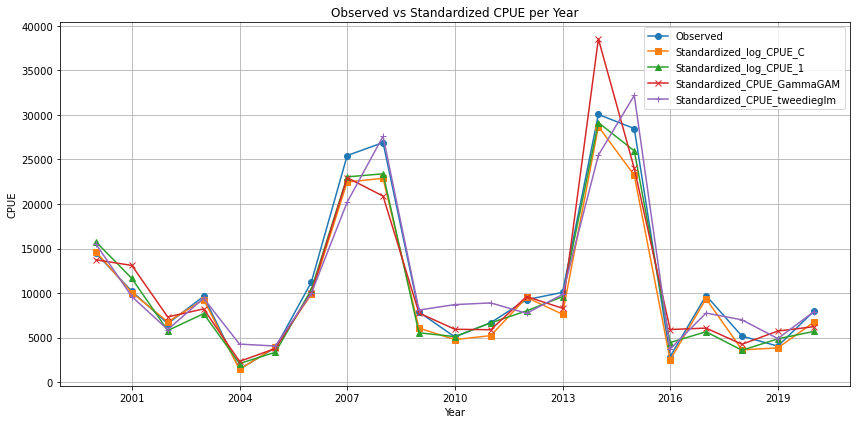

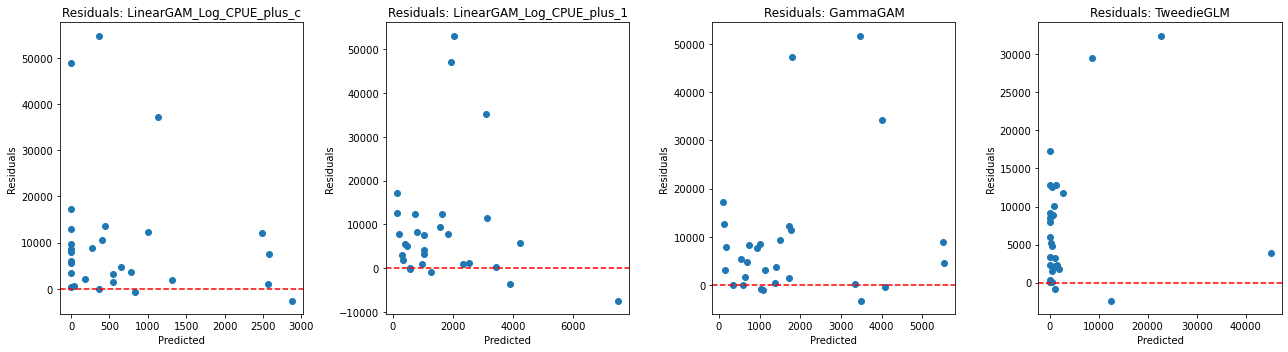

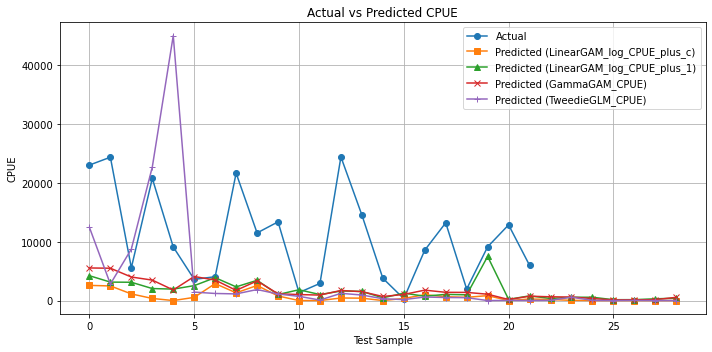

In [203]:
# 6. Visualization
# A. Yearly Standardized vs Observed
yearly = full_df.groupby("Year")["Monthly_CPUE"].mean().reset_index(name="Observed")

yearly_log_cpueC = full_df.copy()
#yearly_log_cpueC["Standardized_log_cpueC"] = standardized_log_cpueC
yearly_log_cpueC = yearly_log_cpueC.groupby("Year")["Standardized_log_cpueC"].mean().reset_index()

yearly_log_cpue1 = full_df.copy()
#yearly_log_cpue1["Standardized_log_cpue1"] = standardized_log_cpue1
yearly_log_cpue1 = yearly_log_cpue1.groupby("Year")["Standardized_log_cpue1"].mean().reset_index()

yearly_cpue_gamma_c = full_df.copy()
#yearly_cpue_gamma_c["GammaGAM_Standardized"] = standardized_cpue_gamma_c
yearly_cpue_gamma_c = yearly_cpue_gamma_c.groupby("Year")["Standardized_CPUE_GammaGAM"].mean().reset_index()

yearly_cpue_gamma_1 = full_df.copy()
#yearly_cpue_gamma_1["GammaGAM_Standardized"] = standardized_cpue_gamma_1
yearly_cpue_gamma_1 = yearly_cpue_gamma_1.groupby("Year")["Standardized_CPUE_tweedieglm"].mean().reset_index()

merged = yearly.merge(yearly_log_cpueC, on="Year").merge(yearly_log_cpue1, on="Year").merge(yearly_cpue_gamma_c, on="Year").merge(yearly_cpue_gamma_1, on="Year")

# Interactive observed vs standardized plot
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=merged["Year"], y=merged["Observed"],mode="lines+markers", name="Observed"))
fig.add_trace(go.Scatter(x=merged["Year"], y=merged["Standardized_log_cpueC"],mode="lines+markers", name="Standardized_log_CPUE_C"))
fig.add_trace(go.Scatter(x=merged["Year"], y=merged["Standardized_log_cpue1"],mode="lines+markers", name="Standardized_log_CPUE_1"))
fig.add_trace(go.Scatter(x=merged["Year"], y=merged["Standardized_CPUE_GammaGAM"],mode="lines+markers", name="Standardized_CPUE_GammaGAM"))
fig.add_trace(go.Scatter(x=merged["Year"], y=merged["Standardized_CPUE_tweedieglm"],mode="lines+markers", name="Standardized_CPUE_TweedieGLM"))

fig = px.line(
    merged,
    x="Year",
    y=["Observed", "Standardized_log_cpueC", "Standardized_log_cpue1", "Standardized_CPUE_GammaGAM", "Standardized_CPUE_tweedieglm"],
    markers=True,
    title="Observed vs Standardized CPUE per Year",
    width=1000,  # increase width
    height=900   # increase height
)

# Layout with fixed integer tick labels on x-axis
fig.update_layout(
    title="Observed vs Standardized CPUE per Year",
    xaxis=dict(title="Year", tickformat=".0f"),  #removes decimals
    yaxis_title="CPUE",
    legend_title="Series",  
    hovermode="x unified",
)

fig.show()

# Static observed vs standardized plot
plt.figure(figsize=(12, 6))
plt.plot(merged["Year"], merged["Observed"], label="Observed", marker="o")
plt.plot(merged["Year"], merged["Standardized_log_cpueC"], label="Standardized_log_CPUE_C", marker="s")
plt.plot(merged["Year"], merged["Standardized_log_cpue1"], label="Standardized_log_CPUE_1", marker="^")
plt.plot(merged["Year"], merged["Standardized_CPUE_GammaGAM"], label="Standardized_CPUE_GammaGAM", marker="x")
plt.plot(merged["Year"], merged["Standardized_CPUE_tweedieglm"], label="Standardized_CPUE_tweedieglm", marker="+")
plt.title("Observed vs Standardized CPUE per Year")
plt.ylabel("CPUE")
plt.xlabel("Year")
plt.legend()
plt.grid(True)
# Force integer ticks on x-axis
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

# B. Residual Plots
residuals_linear_GAM_log_CPUE_plus_c = y_test_linear - linear_gam_c_preds_all
residuals_linear_GAM_log_CPUE_plus_1 = y_test_linear - linear_gam_1_preds_all
residuals_Gamma_GAM = y_test_gamma - gamma_gam_preds
residuals_Tweedie_GLM = y_test_tweedie - tweedie_glm_pred


plt.figure(figsize=(18, 5))

plt.subplot(1, 4, 1)
plt.scatter(linear_gam_c_preds_all, residuals_linear_GAM_log_CPUE_plus_c)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals: LinearGAM_Log_CPUE_plus_c")
plt.xlabel("Predicted")
plt.ylabel("Residuals")

plt.subplot(1, 4, 2)
plt.scatter(linear_gam_1_preds_all, residuals_linear_GAM_log_CPUE_plus_1)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals: LinearGAM_Log_CPUE_plus_1")
plt.xlabel("Predicted")
plt.ylabel("Residuals")

plt.subplot(1, 4, 3)
plt.scatter(gamma_gam_preds, residuals_Gamma_GAM)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals: GammaGAM")
plt.xlabel("Predicted")
plt.ylabel("Residuals")

plt.subplot(1, 4, 4)
plt.scatter(tweedie_glm_pred, residuals_Tweedie_GLM)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals: TweedieGLM")
plt.xlabel("Predicted")
plt.ylabel("Residuals")

plt.tight_layout()
plt.show()

# x-axis index for all predictions
x = list(range(len(y_test)))

# Create interactive figure
fig = go.Figure()

# Add each line as a trace
fig.add_trace(go.Scatter(x=x, y=y_test.values,mode='lines+markers', name='Actual', marker=dict(symbol='circle')))
fig.add_trace(go.Scatter(x=x, y=linear_gam_c_preds_all, mode='lines+markers', name='Predicted (LinearGAM_log_CPUE_plus_c)', marker=dict(symbol='square')))
fig.add_trace(go.Scatter(x=x, y=linear_gam_1_preds_all, mode='lines+markers', name='Predicted (LinearGAM_log_CPUE_plus_1)', marker=dict(symbol='triangle-up')))
fig.add_trace(go.Scatter(x=x, y=gamma_gam_preds, mode='lines+markers', name='Predicted (GammaGAM_CPUE)', marker=dict(symbol='x')))
fig.add_trace(go.Scatter(x=x, y=tweedie_glm_pred, mode='lines+markers', name='Predicted (TweedieGLM_CPUE)', marker=dict(symbol='cross')))

# Customize layout
fig.update_layout(title='Actual vs Predicted CPUE (Interactive)', xaxis_title='Test Sample Index', yaxis_title='CPUE', hovermode='x unified', legend_title='Legend',template='plotly_white')

# Show interactive plot
fig.show()


# C. Actual vs Predicted Plot static plot
x = range(len(y_test))  # common for all
x_linear = range(len(y_test_linear))  # linear_gam
x_gamma = range(len(y_test_gamma))  # gamma
x_tweedie = range(len(y_test_tweedie))  # tweedie
plt.figure(figsize=(10, 5))
plt.plot(x, y_test.values, label="Actual", marker="o")
plt.plot(x_linear, linear_gam_c_preds_all, label="Predicted (LinearGAM_log_CPUE_plus_c)", marker="s")
plt.plot(x_linear, linear_gam_1_preds_all, label="Predicted (LinearGAM_log_CPUE_plus_1)", marker="^")
plt.plot(x_gamma, gamma_gam_preds, label="Predicted (GammaGAM_CPUE)", marker="x")
plt.plot(x_tweedie, tweedie_glm_pred, label="Predicted (TweedieGLM_CPUE)", marker="+")
plt.title("Actual vs Predicted CPUE")
plt.ylabel("CPUE")
plt.xlabel("Test Sample")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# 7. Summary
# =====================
# This notebook performs CPUE standardization using two robust models:
# - GLBM-like model using log(CPUE + c)
# - Generalized Additive Model (GAM) using log(CPUE + 1)
# Both models capture nonlinear relationships with environmental/spatiotemporal features.
# Evaluation includes RMSE/MAE, standardized CPUE comparison by year, and residual analysis.
# Very skewed distribution — a few huge values are dragging the mean way up. This is a classic case for log-transforming the target — which you're doing correctly in some models like GAM(log(CPUE + c)).



# “The Tweedie GLM required careful tuning. I experimented with spline complexity (df) and found that over-smoothing led to poor generalization, while under-smoothing caused instability. The residual plots revealed stacking behavior, which I addressed by tuning the degrees of freedom, scaling inputs, and exploring alternative link functions. Ultimately, GAMs gave better flexibility, but I appreciated Tweedie’s full GLM output and interpretability.”
#If your model’s predictions are always around the same number, it's like it only knows how to say “the answer is 5000” no matter what. Then your errors (residuals) will be all different numbers — but they’re all stacked over 5000 on the x-axis. That’s why your graph looks like a line of dots going up and down — it's just one guess and many mistakes stacked on it.

In [ ]:

#"Generalized Linear Bayesian Model (GLBM) for standardized CPUE =ln(CPUE+c)=factor(year)+factor(month)+s(longitude)+s(latitude)+s(SST)+s(SSH)+s(Chl a)+ϵ. 
# Lu et al. 2013 suggested that  GLBM was a better model to standardize yearly CPUEs for Chinese Mainland which represented the same proportional change 
# in stock size of I. argentinus. The CPUE was assumed to be normally distributed and log-transformed with errors in the GLBM modelling."
# c = constant that was assumed to be 10% of the mean yearly CPUE
# Expected Ln CPUE=Intercept+∑(Coefficients X Predictors)
# Standardized CPUE = exp(Ln CPUE)-c
# Orange hilighted is imputed data (mean of other SST in 2021)

# GLBM (OLS) Model
glm_features = ["Month", "Year", "Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Chlor_a_mg_m3", "SSH", "Depth"]
X_train_glm = train_df[glm_features]
X_test_glm = test_df[glm_features]

# One-hot encode Month and Year
enc = OneHotEncoder(drop='first', sparse_output=False)
X_train_encoded = enc.fit_transform(X_train_glm[["Month", "Year"]])
X_test_encoded = enc.transform(X_test_glm[["Month", "Year"]])

X_train_final = np.hstack([X_train_encoded, X_train_glm[["Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Chlor_a_mg_m3", "SSH", "Depth"]].values])
X_test_final = np.hstack([X_test_encoded, X_test_glm[["Weighted_Latitude", "Weighted_Longitude", "WaterTemp", "Chlor_a_mg_m3", "SSH", "Depth"]].values])

X_train_const = sm.add_constant(X_train_final)
X_test_const = sm.add_constant(X_test_final)
glm_model = sm.OLS(y_train, X_train_const).fit()
glm_preds = glm_model.predict(X_test_const)